## DOTA 2 - Predicting wins using hero and item data

#### By: Ian Herve U. Chu Te

In this notebook, we use a simple decision tree to predict whether *The Radiant* or *The Dire* will win given hero and item data.

The data we use is sourced from Kaggle's Dota 2 Matches dataset. You may download the dataset <a href="https://www.kaggle.com/devinanzelmo/dota-2-matches">here</a>.

### 1. Feature Engineering

The raw dataset does not provide a schema that can be directly modelled. 

We have to engineer the data first before we can proceed to the modelling step.

Firstly, let us import the *pandas* library for easy data wrangling.

In [1]:
import pandas as pd

%matplotlib inline

Then, let us load the pertinent datasets.

Below are their respective descriptions from Kaggle:

1. **players:** Individual players are identified by account_id but there is an option to play anonymously and roughly one third of the account_id are not available. Anonymous users have the value of 0 for account_id. Contains totals for kills, deaths, denies, etc. Player action counts are available, and are indicated by variable names beginning with unit_order. Counts for reasons for acquiring or losing gold, and gaining experience, have prefixes gold, and xp.
2. **matches:** contains top level information about each match.
3. **heroes:** hero lookup
4. **items:** item lookup

**NOTE: **If you wish to reuse this notebook, download the <a href="https://www.kaggle.com/devinanzelmo/dota-2-matches">Kaggle Dataset</a> and unzip it into the *data* folder.

In [2]:
players = pd.read_csv('data/players.csv')
matches = pd.read_csv('data/match.csv')
heroes = pd.read_csv('data/hero_names.csv')
items = pd.read_csv('data/item_ids.csv')

Let us map the *hero_id* field to its name.

In [3]:
hero_lookup = dict(zip(heroes['hero_id'], heroes['localized_name']))
hero_lookup[0] = 'Unknown'
players['hero'] = players['hero_id'].apply(lambda _id: hero_lookup[_id])

Let us map each *item* column field to its name.

In [4]:
item_lookup = dict(zip(items['item_id'], items['item_name']))
item_lookup[0] = 'Unknown'

def find_item(_id):
    return item_lookup.get(_id, 'u_' + str(_id))

players['item_0'] = players['item_0'].apply(find_item)
players['item_1'] = players['item_1'].apply(find_item)
players['item_2'] = players['item_2'].apply(find_item)
players['item_3'] = players['item_3'].apply(find_item)
players['item_4'] = players['item_4'].apply(find_item)
players['item_5'] = players['item_5'].apply(find_item)

Then, let us one-hot encode each player's hero using pandas' get_dummies function:

In [5]:
player_heroes = pd.get_dummies(players['hero'])

Similarly, let us one-hot encode each player's item using pandas' get_dummies function:

In [6]:
item0 = pd.get_dummies(players['item_0'].fillna(0))
item1 = pd.get_dummies(players['item_1'].fillna(0))
item2 = pd.get_dummies(players['item_2'].fillna(0))
item3 = pd.get_dummies(players['item_3'].fillna(0))
item4 = pd.get_dummies(players['item_4'].fillna(0))
item5 = pd.get_dummies(players['item_5'].fillna(0))

Because the position of each item does not matter and also to simplify our feature space, let us sum the item columns to count the number of items per kind of item per player:

In [7]:
player_items = item0 \
    .add(item1, fill_value=0) \
    .add(item2, fill_value=0) \
    .add(item3, fill_value=0) \
    .add(item4, fill_value=0) \
    .add(item5, fill_value=0)

Let us prepare the column names for every hero name for every team:

In [8]:
radiant_cols = list(map(lambda s: 'radiant_' + s, player_heroes.columns.values))
dire_cols = list(map(lambda s: 'dire_' + s, player_heroes.columns.values))

Similarly, let us also prepare the column names for every item name for every team:

In [9]:
radiant_items_cols = list(map(lambda s: 'radiant_' + str(s), player_items.columns.values))
dire_items_cols = list(map(lambda s: 'dire_' + str(s), player_items.columns.values))

Now, let us sum each players hero and item counts so that it will result in one row per match. 

The result is a row that encodes whether or not (1 or 0) a type of hero is present for that team and also the sum of the *combined item counts* for every team - (getting the item per player will be more memory intensive that is why we are just combining per team). 

I also cached the results of this step because it is quite slow. If you are running this notebook from scratch, you will have to compute it at least once.

In [10]:
from os.path import isfile

X = None

if isfile('mapped_match_hero_item.csv'):
    X = pd.read_csv('mapped_match_hero_item.csv')
else:
    radiant_heroes = []
    dire_heroes = []
    radiant_items = []
    dire_items = []

    for _id, _index in players.groupby('match_id').groups.items():
        radiant_heroes.append(player_heroes.iloc[_index][:5].sum().values)
        dire_heroes.append(player_heroes.iloc[_index][5:].sum().values)
        radiant_items.append(player_items.iloc[_index][:5].sum().values)
        dire_items.append(player_items.iloc[_index][5:].sum().values)

    radiant_heroes = pd.DataFrame(radiant_heroes, columns=radiant_cols)
    dire_heroes = pd.DataFrame(dire_heroes, columns=dire_cols)
    radiant_items = pd.DataFrame(radiant_items, columns=radiant_items_cols)
    dire_items = pd.DataFrame(dire_items, columns=dire_items_cols)
    X = pd.concat([radiant_heroes, radiant_items, dire_heroes, dire_items], axis=1)
    X.to_csv('mapped_match_hero_item.csv', index=False)

Now, we have our predictors:

In [11]:
X.head()

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,dire_vanguard,dire_veil_of_discord,dire_vitality_booster,dire_vladmir,dire_void_stone,dire_ward_dispenser,dire_ward_observer,dire_ward_sentry,dire_wraith_band,dire_yasha
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Now, let us properly encode the target column:

In [12]:
y = matches['radiant_win'].apply(lambda win: 1 if win else 0)
classes = ['Dire Win', 'Radiant Win']

Also, let us look at the split - it seems to be almost evenly split. 

That means that CV scores greater than around 50% are considered useful for prediction.

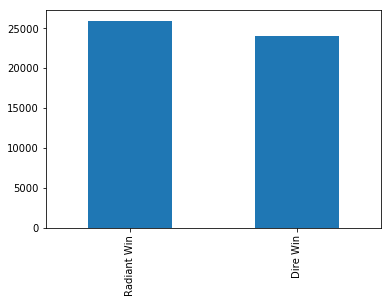

In [13]:
_ = pd.Series(y).apply(lambda i: classes[i]).value_counts().plot('bar')

### 2. Predictive Modelling

Now that we have our **X** and **y** datasets, let us now proceed to the predictive modelling step.

First, we import python libraries which we will use for modelling and visualing the final model:

In [14]:
import io
from scipy import misc
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pydotplus

Then, we define a function that can show us our decision tree model:

In [15]:
def show_tree(decisionTree, file_path):
    dotfile = io.StringIO()
    export_graphviz(decisionTree, 
                    max_depth=4,
                    label=None,
                    impurity=False,
                    filled=True,
                    rounded=True,
                    proportion=False,
                    rotate=True,
                    out_file=dotfile, 
                    class_names=classes, 
                    feature_names=X.columns)
    pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png(file_path)
    i = misc.imread(file_path)
    plt.figure(figsize=(100,100))
    plt.imshow(i, interpolation='nearest')

Also, we define a wrapper that cross-validates, fits and displays our model for easy reuse:

In [16]:
def build_decision_tree(X, y, depth=None):
    dt = DecisionTreeClassifier(random_state=42, max_depth=depth)
    print('CV score:', cross_val_score(estimator=dt, X=X, y=y).mean())
    dt.fit(X, y)
    show_tree(dt, 'tree.png')
    return dt

Now, for the much awaited step, let us model the data. 

As can be seen below, we have obtained a CV score of **83%** - way above the 50% split.
This shows that, the heroes and items are indeed predictive of victory or defeat in DOTA 2. 

Important items are: 
1. Boots of Travel
2. Gem of True Sight
3. Ogre Axe
4. Aegis (from Roshan) 
5. Heart of Tarasque

The only hero mentioned in the upper portions of the decision tree is the **Necrophos** - one of the most effective mass healers in the game.

CV score: 0.833480005067


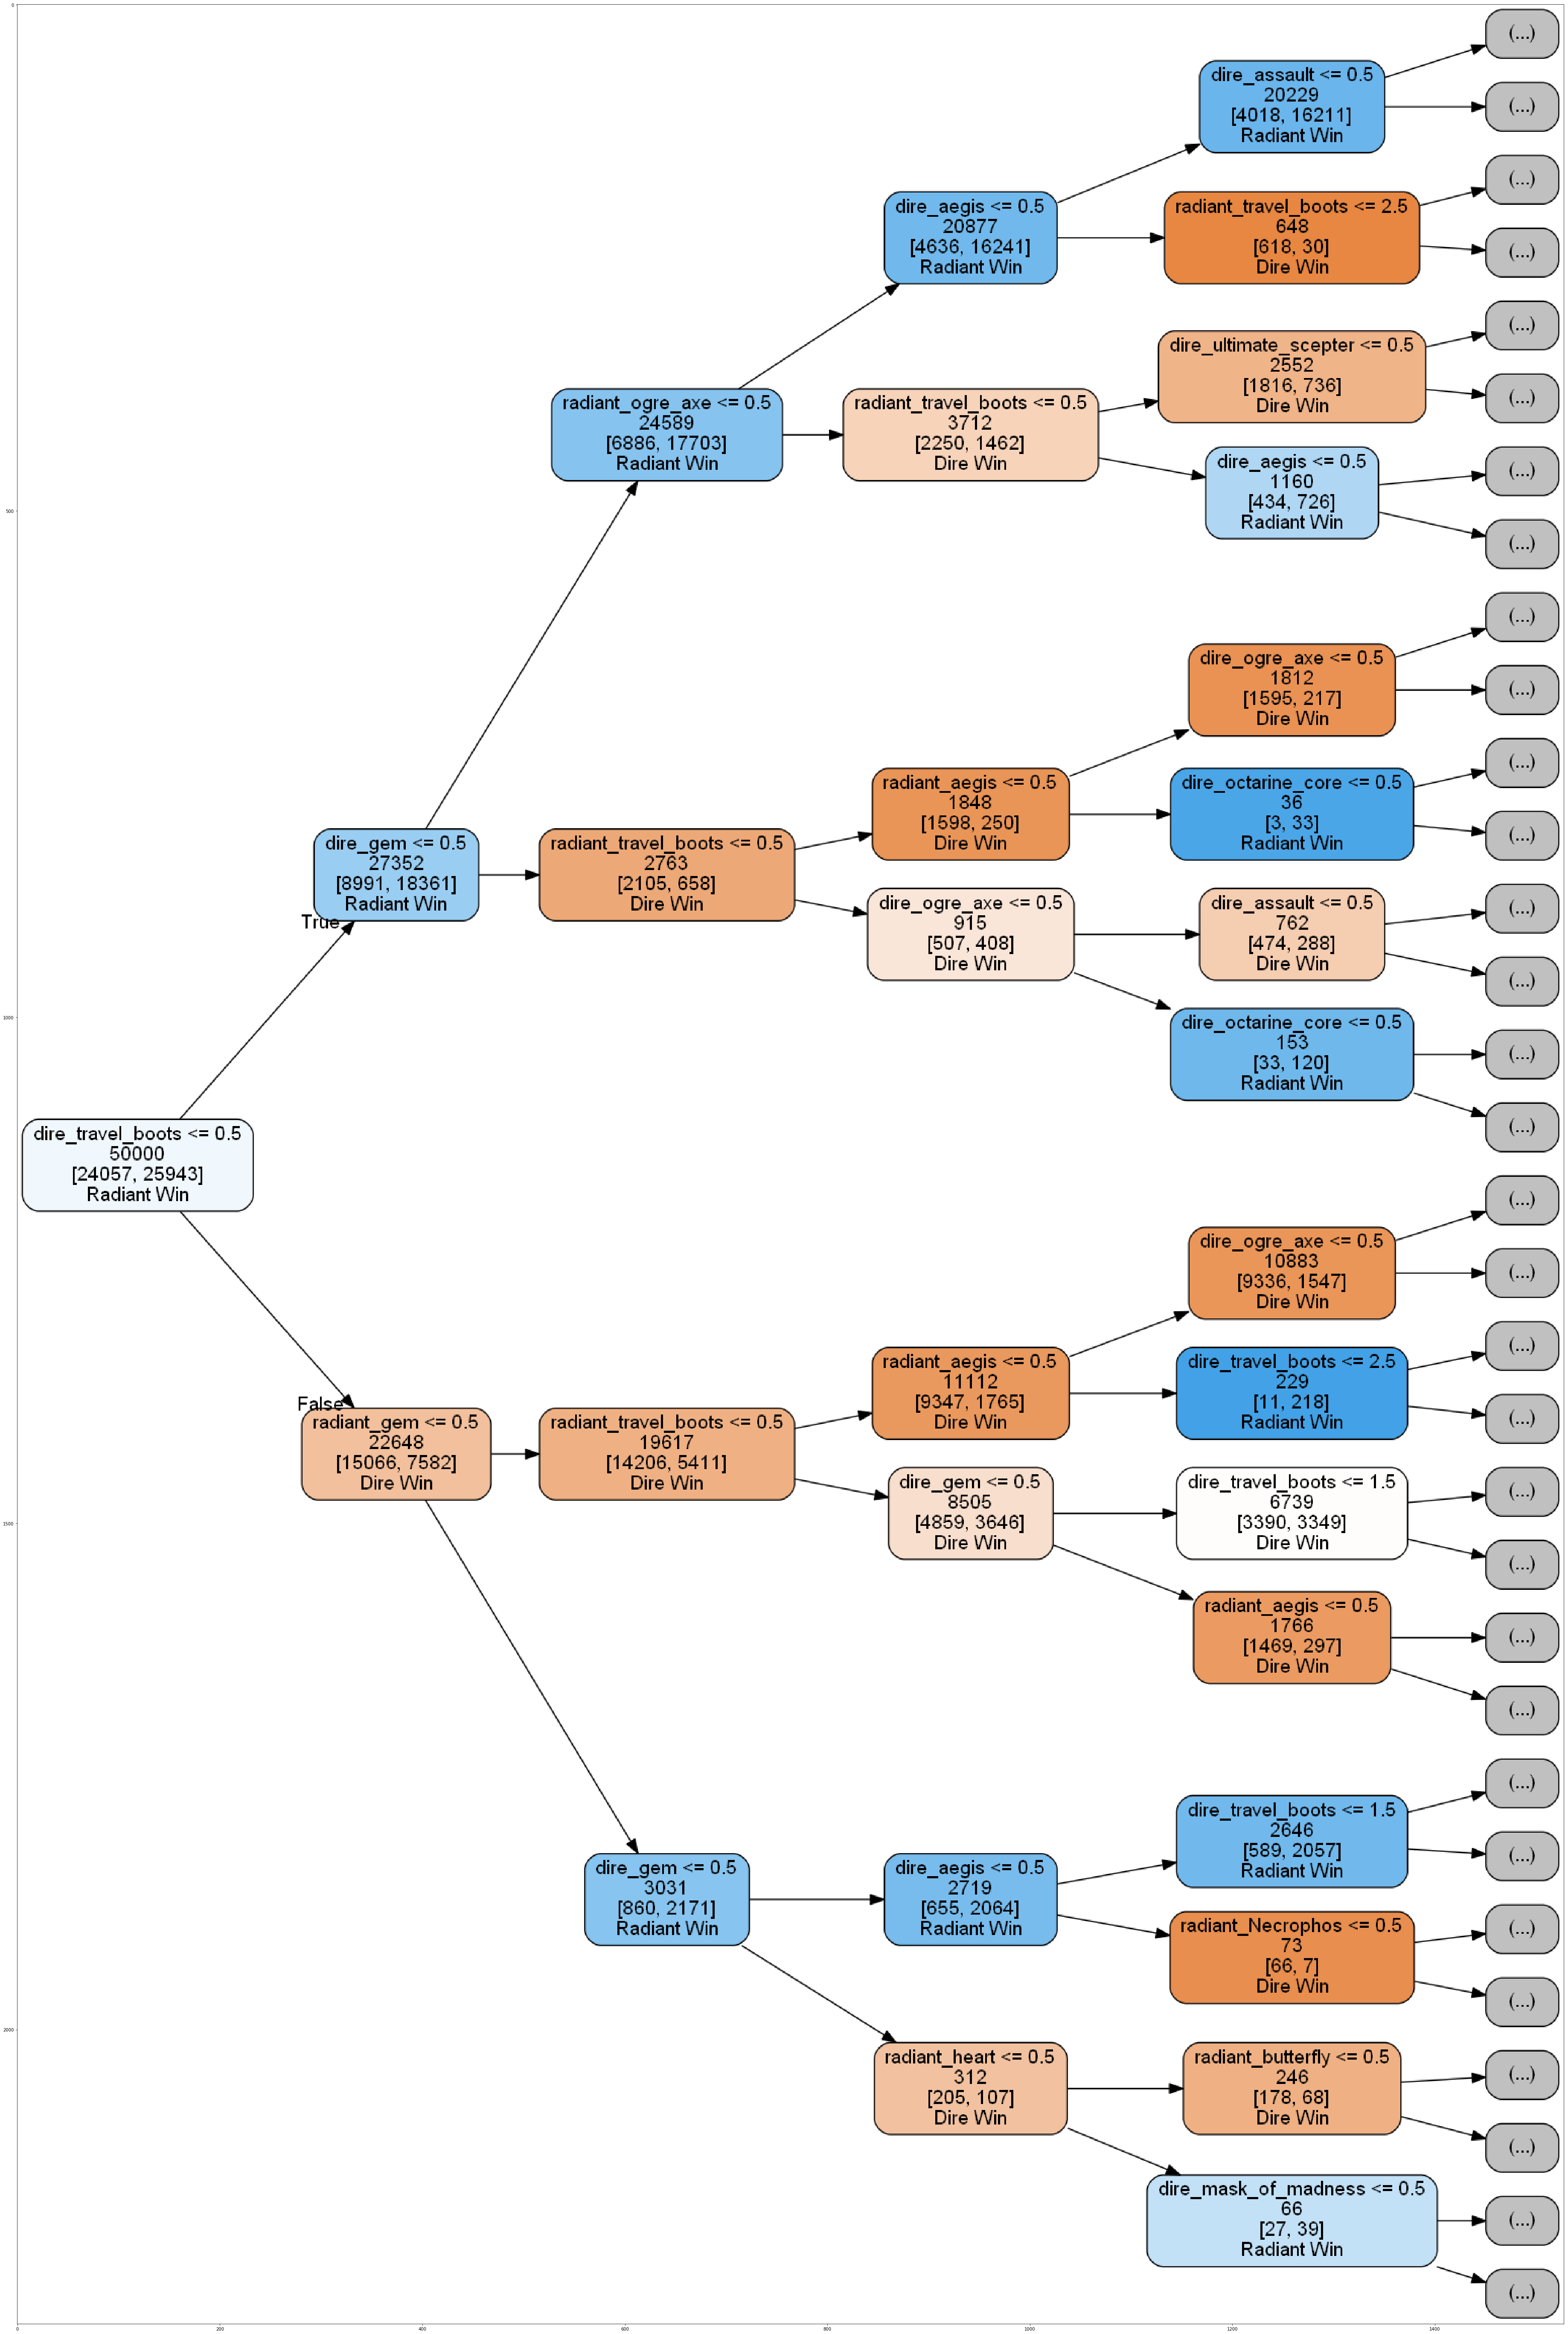

In [17]:
dt = build_decision_tree(X=X, y=y, depth=10)

Other important factors can also be seen below by extracting the feature importances of the tree:

In [18]:
def get_tree_stats(dt):
    feature_importances = dict(zip(X.columns, dt.feature_importances_))
    feature_importances = pd.Series(feature_importances).sort_values(ascending=False)
    return feature_importances.iloc[feature_importances.nonzero()]

get_tree_stats(dt).head(20)

dire_travel_boots          0.203223
dire_gem                   0.104874
radiant_travel_boots       0.103673
radiant_gem                0.077311
radiant_ogre_axe           0.062642
dire_aegis                 0.059328
dire_assault               0.047569
radiant_Unknown.1          0.040661
radiant_aegis              0.033091
dire_butterfly             0.028862
dire_ogre_axe              0.025828
radiant_assault            0.020026
dire_Unknown.1             0.018916
dire_guardian_greaves      0.018145
dire_ultimate_scepter      0.013536
radiant_butterfly          0.012071
dire_abyssal_blade         0.010682
radiant_monkey_king_bar    0.010277
radiant_abyssal_blade      0.007701
dire_moon_shard            0.007699
dtype: float64